In [11]:
!pip install git+https://github.com/pantelis-classes/PRML.git#egg=prml

import seaborn as sns

# Apply the default theme
sns.set_theme()

  Cloning https://github.com/pantelis-classes/PRML.git to /tmp/pip-install-j0r5p1xw/prml_d2bb53a1c6f64a7390a207b8fc03c0cd
  Running command git clone --filter=blob:none --quiet https://github.com/pantelis-classes/PRML.git /tmp/pip-install-j0r5p1xw/prml_d2bb53a1c6f64a7390a207b8fc03c0cd
  Resolved https://github.com/pantelis-classes/PRML.git to commit 6c7ef85da419a644a4a4feb7ab538d2f4f15d46b
  Preparing metadata (setup.py) ... done


Epoch 0: Loss = 2.0339276790618896
Epoch 100: Loss = 0.5981771349906921
Epoch 200: Loss = 0.509158730506897
Epoch 300: Loss = 0.4565465748310089
Epoch 400: Loss = 0.4154232442378998
Epoch 500: Loss = 0.38205674290657043
Epoch 600: Loss = 0.354819118976593
Epoch 700: Loss = 0.33251506090164185
Epoch 800: Loss = 0.314191609621048
Epoch 900: Loss = 0.29908129572868347


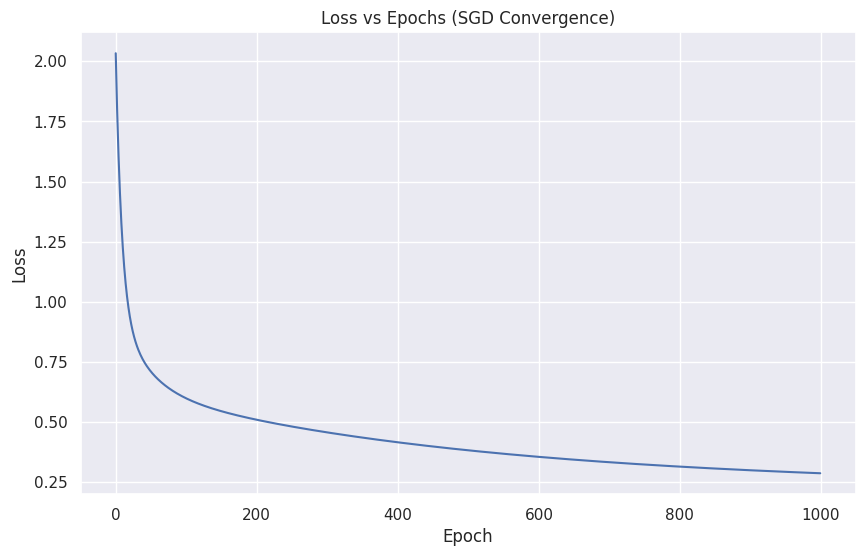

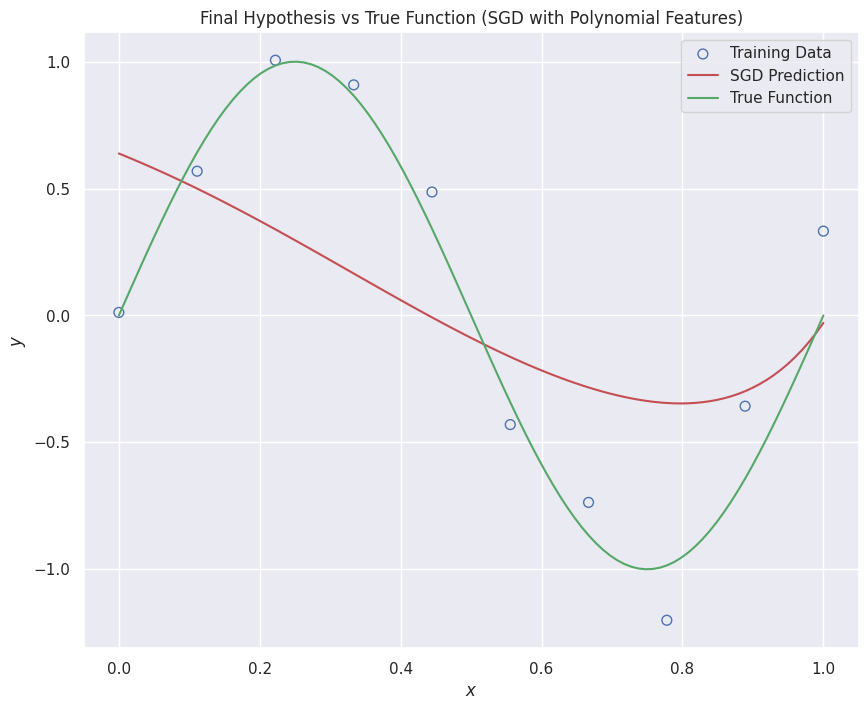

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

# Hyperparameters
learning_rate = 0.01
epochs = 1000
lambda_reg = 1e-3
M = 9

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

x_test = np.linspace(0, 1, 100)
x_test_torch = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)

class PolynomialFeature:
    def __init__(self, degree):
        self.degree = degree

    def transform(self, x):
        return torch.cat([x ** i for i in range(self.degree + 1)], dim=1)

poly_feature = PolynomialFeature(M)
X_train = poly_feature.transform(x_train)
X_test = poly_feature.transform(x_test_torch)

w = torch.randn(M + 1, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

loss_values = []

for epoch in range(epochs):
    y_pred = X_train @ w + b

    mse_loss = torch.mean((y_pred - y_train) ** 2)
    reg_loss = lambda_reg * torch.sum(w ** 2)
    loss = mse_loss + reg_loss

    loss.backward()

    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

        w.grad.zero_()
        b.grad.zero_()

    loss_values.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item()}')

plt.figure(figsize=[10,6])
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs (SGD Convergence)')
plt.grid(True)
plt.show()

with torch.no_grad():
    y_pred_test = X_test @ w + b

plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training Data")
plt.plot(x_test, y_pred_test.numpy(), label="SGD Prediction", color='r')
plt.plot(x_test, sinusoidal(x_test), label="True Function", color='g')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Final Hypothesis vs True Function (SGD with Polynomial Features)")
plt.show()


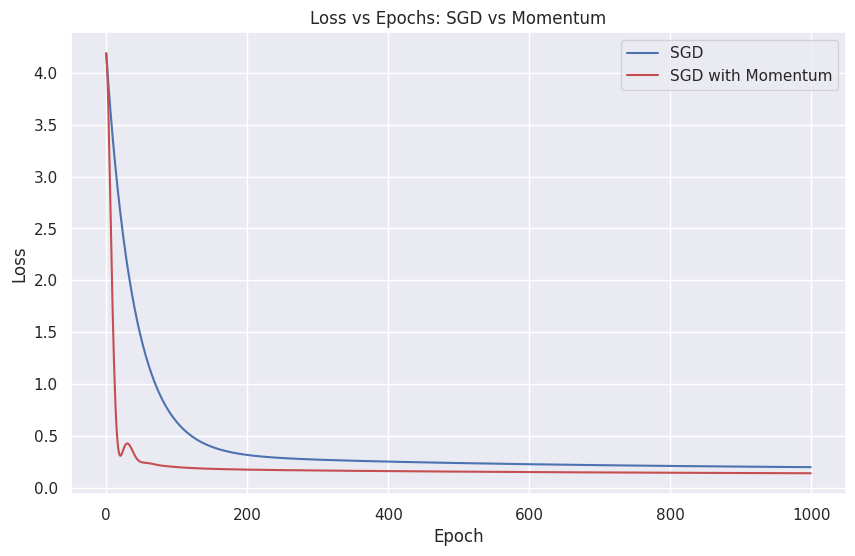

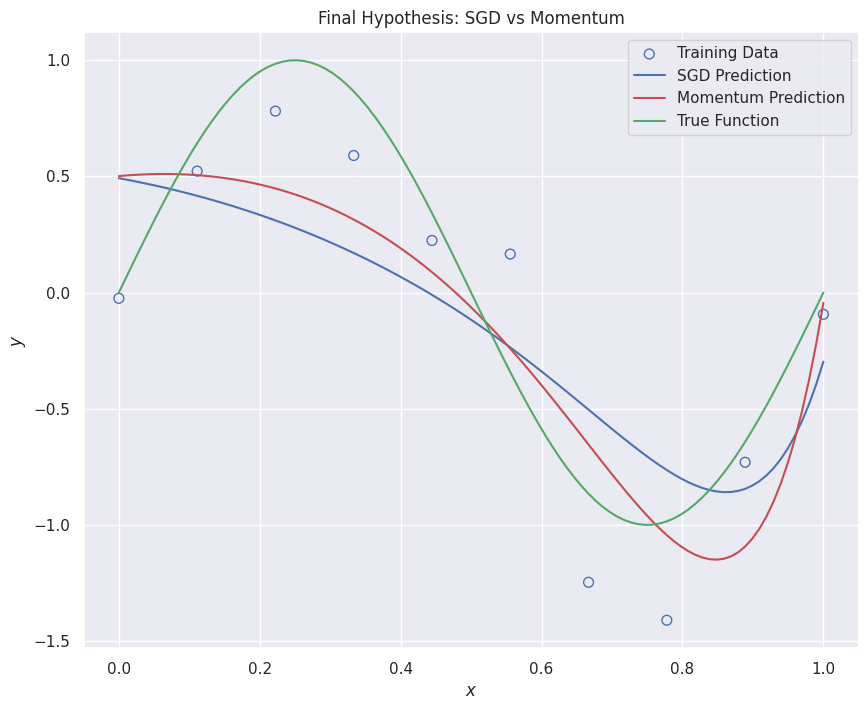

In [14]:
#With momentum

learning_rate = 0.01
epochs = 1000
lambda_reg = 1e-3
momentum = 0.9
M = 9

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_train = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

x_test = np.linspace(0, 1, 100)
x_test_torch = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)

class PolynomialFeature:
    def __init__(self, degree):
        self.degree = degree

    def transform(self, x):
        return torch.cat([x ** i for i in range(self.degree + 1)], dim=1)

poly_feature = PolynomialFeature(M)
X_train = poly_feature.transform(x_train)
X_test = poly_feature.transform(x_test_torch)

w_sgd = torch.randn(M + 1, 1, requires_grad=True)
b_sgd = torch.randn(1, requires_grad=True)
w_momentum = w_sgd.clone().detach().requires_grad_(True)
b_momentum = b_sgd.clone().detach().requires_grad_(True)

def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

v_w, v_b = init_momentum_states(M + 1)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss_sgd = []
loss_momentum = []

for epoch in range(epochs):
    y_pred_sgd = X_train @ w_sgd + b_sgd
    mse_loss_sgd = torch.mean((y_pred_sgd - y_train) ** 2)
    reg_loss_sgd = lambda_reg * torch.sum(w_sgd ** 2)
    loss_sgd_total = mse_loss_sgd + reg_loss_sgd
    loss_sgd_total.backward()

    with torch.no_grad():
        w_sgd -= learning_rate * w_sgd.grad
        b_sgd -= learning_rate * b_sgd.grad
        w_sgd.grad.zero_()
        b_sgd.grad.zero_()

    loss_sgd.append(loss_sgd_total.item())

    y_pred_momentum = X_train @ w_momentum + b_momentum
    mse_loss_momentum = torch.mean((y_pred_momentum - y_train) ** 2)
    reg_loss_momentum = lambda_reg * torch.sum(w_momentum ** 2)
    loss_momentum_total = mse_loss_momentum + reg_loss_momentum
    loss_momentum_total.backward()

    sgd_momentum([w_momentum, b_momentum], [v_w, v_b], {'lr': learning_rate, 'momentum': momentum})

    loss_momentum.append(loss_momentum_total.item())

plt.figure(figsize=[10,6])
plt.plot(loss_sgd, label="SGD", color='b')
plt.plot(loss_momentum, label="SGD with Momentum", color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs: SGD vs Momentum')
plt.legend()
plt.grid(True)
plt.show()


with torch.no_grad():
    y_pred_test_sgd = X_test @ w_sgd + b_sgd
    y_pred_test_momentum = X_test @ w_momentum + b_momentum


plt.figure(figsize=[10,8])
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training Data")
plt.plot(x_test, y_pred_test_sgd.numpy(), label="SGD Prediction", color='b')
plt.plot(x_test, y_pred_test_momentum.numpy(), label="Momentum Prediction", color='r')
plt.plot(x_test, sinusoidal(x_test), label="True Function", color='g')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Final Hypothesis: SGD vs Momentum")
plt.show()
